In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 5.5MB/s 
     |████████████████████████████████| 194kB 8.7MB/s 
     |████████████████████████████████| 51kB 5.1MB/s 
     |████████████████████████████████| 1.1MB 12.1MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [19]:
key = os.environ.get('AZURE_SEARCH_KEY', '1c5b6f6bc76f42bf88375d03a82615f8')

In [80]:
def search_images_bing(subscription_key, search_term, size = 300):
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    headers = {"Ocp-Apim-Subscription-Key" : subscription_key}

    params  = {"q": search_term, 
               "license": "public", 
               "imageType": "photo",
               "count": size}

    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()
    
    reformatted_results = L(search_results["value"], use_list=True)
    # Uses the FastAI class L, a
    # "drop-in" replacement for Lists. Mixes Python standard library and numpy arrays.
    # I'm putting this here so, again, we minimize the amount of individual cells rewritten.
    # Many of the later cells assume .attrgot is a valid thing you can call.
    
    for result in reformatted_results:
        result["content_url"] = result["contentUrl"]
    # Bing changed their API. They return contentUrl instead of content_url. 
    # Again, this will help in the long run. 
    
    return reformatted_results

In [81]:
results = search_images_bing(key, 'worker hard hat')
images = results.attrgot('content_url')
len(images)

149

In [86]:
hardhats = ['people', 'hard hat']
path = Path('construction7')

In [87]:
if not path.exists():
    path.mkdir()
    for t in hardhats:
        dest = (path/t)
        print(dest)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, '{} people'.format(t))
        download_images(dest, urls=results.attrgot('content_url'))

construction7/people


construction7/hard hat


In [85]:
files = get_image_files(path)
files

(#151) [Path('construction6/people/00000040.jpg'),Path('construction6/people/00000029.jpg'),Path('construction6/people/00000062.jpg'),Path('construction6/people/00000037.jpg'),Path('construction6/people/00000031.jpg'),Path('construction6/people/00000076.jpg'),Path('construction6/people/00000021.jpg'),Path('construction6/people/00000024.jpeg'),Path('construction6/people/00000033.jpg'),Path('construction6/people/00000097.jpg')...]

In [67]:
corrupt = verify_images(files)
corrupt

(#3) [Path('construction6/people/00000034.jpg'),Path('construction6/people/00000036.jpg'),Path('construction6/hard hat/00000033.png')]

In [68]:
corrupt.map(Path.unlink);

In [70]:
hats = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=get_image_files,
        splitter=RandomSplitter(valid_pct=0.2, seed=41),
        get_y=parent_label,
        item_tfms=Resize(128)
        )

In [71]:
dls = hats.dataloaders(path)

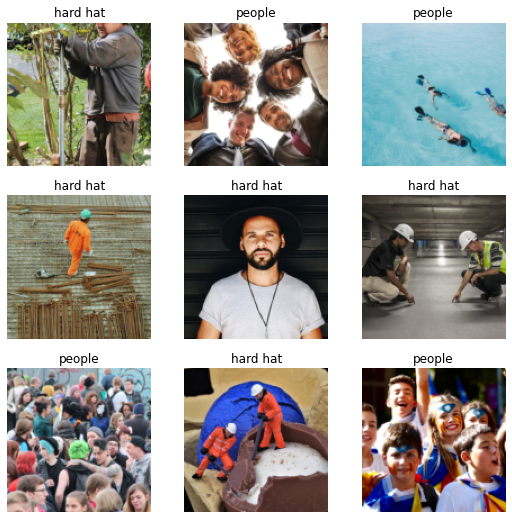

In [72]:
dls.valid.show_batch()

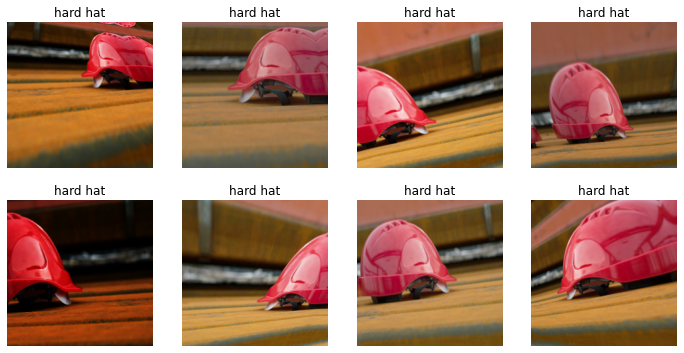

In [73]:
##adding item transformations
hats = hats.new(
                item_tfms=RandomResizedCrop(224, min_scale=0.5), 
                batch_tfms=aug_transforms(mult=2)
               )
dls = hats.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [76]:
model = cnn_learner(dls, resnet18, metrics=error_rate)
model.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.302597,1.267843,0.433333,00:30


epoch,train_loss,valid_loss,error_rate,time
0,1.105083,1.033358,0.400000,00:34
1,1.157502,1.065089,0.433333,00:32
2,1.081630,1.210091,0.433333,00:34
3,0.931823,1.150085,0.400000,00:33


In [77]:
model.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
#model_inf = load_learner('/content/drive/MyDrive/test/export.pkl')
model_inf = load_learner('/content/drive/MyDrive/test/export.pkl')

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import pickle
##dump the model into a file
with open("model.bin", 'wb') as f_out:
    pickle.dump(model, f_out) # write final_model in .bin file
    f_out.close()  # close the file 

In [ ]:
model_inf.predict('/content/drive/MyDrive/test/nohat.jpg')

('people', tensor(1), tensor([0.2521, 0.7479]))

In [ ]:
model_inf.dls.vocab

['hard hat', 'people']